# Fully Convolutional Networks (FCN)

We previously discussed semantic segmentation using each pixel in an image for category prediction. A fully convolutional network (FCN) uses a convolutional neural network to transform image pixels to pixel categories. Unlike the convolutional neural networks previously introduced, an FCN transforms the height and width of the intermediate layer feature map back to the size of input image through the transposed convolution layer, so that the predictions have a one-to-one correspondence with input image in spatial dimension (height and width). Given a position on the spatial dimension, the output of the channel dimension will be a category prediction of the pixel corresponding to the location.

We will first import the package or module needed for the experiment and then explain the transposed convolution layer.

In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import numpy as np
import sys

## Transposed Convolution Layer

The transposed convolution layer takes its name from the matrix transposition operation. In fact, convolution operations can also be achieved by matrix multiplication. In the example below, we define input `X` with a height and width of 4 respectively, and a convolution kernel `K` with a height and width of 3 respectively. Print the output of the 2D convolution operation and the convolution kernel. As you can see, the output has a height and a width of 2.

In [2]:
X = nd.arange(1, 17).reshape((1, 1, 4, 4))
K = nd.arange(1, 10).reshape((1, 1, 3, 3))
conv = nn.Conv2D(channels=1, kernel_size=3)
conv.initialize(init.Constant(K))
conv(X), K

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[[[1. 2. 3.]
    [4. 5. 6.]
    [7. 8. 9.]]]]
 <NDArray 1x1x3x3 @cpu(0)>)

Next, we rewrite convolution kernel `K` as a sparse matrix `W` with a large number of zero elements, i.e. a weight matrix. The shape of the weight matrix is (4,16), where the non-zero elements are taken from the elements in convolution kernel `K`. Enter `X` and concatenate line by line to get a vector of length 16. Then, perform matrix multiplication for `W` and the `X` vector to get a vector of length 4. After the transformation, we can get the same result as the convolution operation above. As you can see, in this example, we implement the convolution operation using matrix multiplication.

In [3]:
W, k = nd.zeros((4, 16)), nd.zeros(11)
k[:3], k[4:7], k[8:] = K[0, 0, 0, :], K[0, 0, 1, :], K[0, 0, 2, :]
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
nd.dot(W, X.reshape(16)).reshape((1, 1, 2, 2)), W

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0. 0.]
  [0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0.]
  [0. 0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9.]]
 <NDArray 4x16 @cpu(0)>)

Now we will describe the convolution operation from the perspective of matrix multiplication. Let the input vector be $\boldsymbol{x}$ and weight matrix be $\boldsymbol{W}$. The implementation of the convolutional forward computation function can be considered as the multiplication of the function input by the weight matrix to output the vector $\boldsymbol{ y} = \boldsymbol{W}\boldsymbol{x}$. We know that back propagation needs to be based on chain rules. Because $\nabla_{\boldsymbol{x}} \boldsymbol{y} = \boldsymbol{W}^\top$, the implementation of the convolutional back propagation function can be considered as the multiplication of the function input by the transposed weight matrix $\boldsymbol{W}^\top$. The transposed convolution layer exchanges the forward computation function and the back propagation function of the convolution layer. These two functions can be regarded as the multiplication of the function input vectors by $\boldsymbol{W}^\top$ and $\boldsymbol{W}$, respectively.

It is not difficult to see that the transposed convolution layer can be used to exchange the shape of input and output of the convolution layer. Let us continue to describe convolution using matrix multiplication. Let the weight matrix be a matrix with a shape of $4\times16$. For an input vector of length 16, the convolution forward computation outputs a vector with a length of 4. If the length of the input vector is 4 and the shape of the transpose weight matrix is $16\times4$, then the transposed convolution layer outputs a vector of length 16. In model design, transposed convolution layers are often used to transform smaller feature maps into larger ones. In a full convolutional network, when the input is a feature map with a high height and a wide width, the transposed convolution layer can be used to magnify the height and width to the size of the input image.

Now we will look at an example. Construct a convolution layer `conv` and let shape of input `X` be (1,3,64,64). The number of channels for convolution output `Y` is increased to 10, but the height and width are reduced by half.

In [4]:
conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv.initialize()

X = nd.random.uniform(shape=(1, 3, 64, 64))
Y = conv(X)
Y.shape

(1, 10, 32, 32)

Next, we construct transposed convolution layer `conv_trans` by creating a `Conv2DTranspose` instance. Here, we assume the convolution kernel shape, padding, and stride of `conv_trans` are the same with those in `conv`, and the number of output channels is 3. When the input is output `Y` of the convolution layer `conv`, the transposed convolution layer output has the same height and width as convolution layer input. The transposed convolution layer magnifies the height and width of the feature map by a factor of 2.

In [5]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize()
conv_trans(Y).shape

(1, 3, 64, 64)

In the literature, transposed convolution is also sometimes referred to as fractionally-strided convolution[2].


## Construct a Model

Here, we demonstrate the most basic design of a fully convolutional network model. As shown in Figure 9.11, the fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer. The model output has the same height and width as the input image and has a one-to-one correspondence in spatial positions. The final output channel contains the category prediction of the pixel of the corresponding spatial position.

![Fully convolutional network. ](../img/fcn.svg)

Below, we use a ResNet-18 model pre-trained on the ImageNet data set to extract image features and record the network instance as `pretrained_net`. As you can see, the last two layers of the model member variable `features` are the global maximum pooling layer `GlobalAvgPool2D` and example flattening layer `Flatten`. The `output` module contains the fully connected layer used for output. These layers are not required for a fully convolutional network.

In [6]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

([BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512),
  Activation(relu),
  GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True),
  Flatten],
 Dense(512 -> 1000, linear))

Next, we create the fully convolutional network instance `net`. It duplicates all the neural layers except the last two layers of the instance member variable `features` of `pretrained_net` and the model parameters obtained after pre-training.

In [7]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

Given an input of a height and width of 320 and 480 respectively, the forward computation of `net` will reduce the height and width of the input to $1/32$ of the original, i.e. 10 and 15.

In [8]:
X = nd.random.uniform(shape=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

Next, we transform the number of output channels to the number of categories of Pascal VOC2012 (21) through the $1\times 1$ convolution layer. Finally, we need to magnify the height and width of the feature map by a factor of 32 to change them back to the height and width of the input image. Recall the calculation method for the convolution layer output shape described in the section ["Padding and Stride"](../chapter_convolutional-neural-networks/padding-and-strides.md). Because $(320-64+16\times2+32)/32=10$ and $(480-64+16\times2+32)/32=15$, we construct a transposed convolution layer with a stride of 32 and set the height and width of the convolution kernel to 64 and the padding to 16. It is not difficult to see that, if the stride is $s$, the padding is $s/2$ (assuming $s/2$ is an integer), and the height and width of the convolution kernel are $2s$, the transposed convolution kernel will magnify both the height and width of the input by a factor of $s$.

In [9]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,
                           strides=32))

## Initialize the Transposed Convolution Layer

We already know that the transposed convolution layer can magnify a feature map. In image processing, sometimes we need to magnify the image, i.e. upsampling. There are many methods for upsampling, and one common method is bilinear interpolation. Simply speaking, in order to get the pixel of the output image at the coordinates $(x, y)$, the coordinates are first mapped to the coordinates of the input image $(x', y')$. This can be done based on the ratio of the size of thee input to the size of the output. The mapped values $x'$ and $y'$ are usually real numbers. Then, we find the four pixels closest to the coordinate $(x', y')$ on the input image. Finally, the pixels of the output image at coordinates $(x, y)$ are calculated based on these four pixels on the input image and their relative distances to $(x', y')$. Upsampling by bilinear interpolation can be implemented by transposed convolution layer of the convolution kernel constructed using the following `bilinear_kernel` function. Due to space limitations, we only give the implementation of the `bilinear_kernel` function and will not discuss the principles of the algorithm.

In [10]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

Now, we will experiment with bilinear interpolation upsampling implemented by transposed convolution layers. Construct a transposed convolution layer that magnifies height and width of input by a factor of 2 and initialize its convolution kernel with the `bilinear_kernel` function.

In [11]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

Read the image `X` and record the result of upsampling as `Y`. In order to print the image, we need to adjust the position of the channel dimension.

In [12]:
img = image.imread('../img/catdog.jpg')
X = img.astype('float32').transpose((2, 0, 1)).expand_dims(axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose((1, 2, 0))

As you can see, the transposed convolution layer magnifies both the height and width of the image by a factor of 2. It is worth mentioning that, besides to the difference in coordinate scale, the image magnified by bilinear interpolation and original image printed in the ["Object Detection and Bounding Box"](bounding-box.md) section look the same.

input image shape: (561, 728, 3)
output image shape: (1122, 1456, 3)


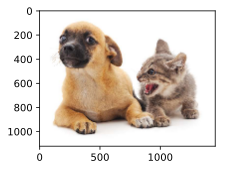

In [13]:
gb.set_figsize()
print('input image shape:', img.shape)
gb.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
gb.plt.imshow(out_img.asnumpy());

In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation. For a $1\times 1$ convolution layer, we use Xavier for randomly initialization.

In [14]:
net[-1].initialize(init.Constant(bilinear_kernel(num_classes, num_classes,
                                                 64)))
net[-2].initialize(init=init.Xavier())

## Read the Data Set

We read the data set using the method described in the previous section. Here, we specify shape of the randomly cropped output image as $320\times 480$, so both the height and width are divisible by 32.

In [15]:
crop_size, batch_size, colormap2label = (320, 480), 32, nd.zeros(256**3)
for i, cm in enumerate(gb.VOC_COLORMAP):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
voc_dir = gb.download_voc_pascal(data_dir='../data')

num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(
    gb.VOCSegDataset(True, crop_size, voc_dir, colormap2label), batch_size,
    shuffle=True, last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(
    gb.VOCSegDataset(False, crop_size, voc_dir, colormap2label), batch_size,
    last_batch='discard', num_workers=num_workers)

read 1114 examples


read 1078 examples


## Training

Now we can start training the model. The loss function and accuracy calculation here are not substantially different from those used in image classification. Because we use the channel of the transposed convolution layer to predict pixel categories, the `axis=1` (channel dimension) option is specified in `SoftmaxCrossEntropyLoss`. In addition, the model calculates the accuracy based on whether the prediction category of each pixel is correct.

In [16]:
ctx = gb.try_all_gpus()
loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1,
                                                      'wd': 1e-3})
gb.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)

training on [gpu(0), gpu(1)]


epoch 1, loss 1.2725, train acc 0.746, test acc 0.817, time 26.2 sec


epoch 2, loss 0.5695, train acc 0.830, test acc 0.841, time 20.1 sec


epoch 3, loss 0.4595, train acc 0.855, test acc 0.849, time 20.1 sec


epoch 4, loss 0.3786, train acc 0.877, test acc 0.849, time 20.2 sec


epoch 5, loss 0.3327, train acc 0.891, test acc 0.850, time 20.3 sec


## Prediction

During predicting, we need to standardize the input image in each channel and transform them into the four-dimensional input format required by the convolutional neural network.

In [17]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = X.transpose((2, 0, 1)).expand_dims(axis=0)
    pred = nd.argmax(net(X.as_in_context(ctx[0])), axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

To visualize the predicted categories for each pixel, we map the predicted categories back to their labeled colors in the data set.

In [18]:
def label2image(pred):
    colormap = nd.array(gb.VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

The size and shape of the images in the test data set vary. Because the model uses a transposed convolution layer with a stride of 32, when the height or width of the input image is not divisible by 32, the height or width of the transposed convolution layer output deviates from the size of the input image. In order to solve this problem, we can crop multiple rectangular areas in the image with heights and widths as integer multiples of 32, and then perform forward computation on the pixels in these areas. When combined, these areas must completely cover the input image. When a pixel is covered by multiple areas, the average of the transposed convolution layer output in the forward computation of the different areas can be used as an input for the softmax operation to predict the category.

For the sake of simplicity, we only read a few large test images and crop an area with a shape of $320\times480$ from the top-left corner of the image. Only this area is used for prediction. For the input image, we print the cropped area first, then print the predicted result, and finally print the labeled category.

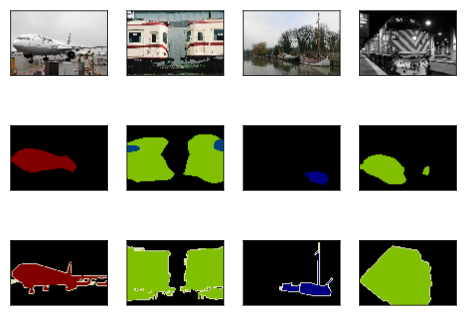

In [19]:
test_images, test_labels = gb.read_voc_images(is_train=False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
gb.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);

## Summary

* We can implement convolution operations by matrix multiplication.
* The fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer to output the category of each pixel.
* In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation.


## Problems

* Is it efficient to use matrix multiplication to implement convolution operations? Why?
* If we use Xavier to randomly initialize the transposed convolution layer, what will happen to the result?
* Can you further improve the accuracy of the model by tuning the hyper-parameters?
* Predict the categories of all pixels in the test image.
* The outputs of some intermediate layers of the convolutional neural network are also used in the paper on fully convolutional networks[1]. Try to implement this idea.

## References

[1] Long, J., Shelhamer, E., & Darrell, T. (2015). Fully convolutional networks for semantic segmentation. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 3431-3440).

[2] Dumoulin, V., & Visin, F. (2016). A guide to convolution arithmetic for deep learning. arXiv preprint arXiv:1603.07285.

## Discuss on our Forum

<div id="discuss" topic_id="2454"></div>